# Data Wrangling and EDA

In [27]:
# import the libraries
import json
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

from tensorflow.keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras.layers import InputLayer
from keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.callbacks import EarlyStopping

import pickle

In [3]:
# check the features
df = pd.read_json("C://Users//kurt_//Downloads//planesnet.json (1)//planesnet.json")
df.head()

,data,labels,locations,scene_ids
0,"[206, 195, 187, 183, 177, 175, 174, 193, 198, ...",1,"[-118.40497658522878, 33.940618514147936]",20170620_175442_0e30
1,"[215, 209, 200, 196, 192, 197, 205, 168, 155, ...",1,"[-122.392469714, 37.6176425378]",20161212_180859_0e30
2,"[204, 214, 220, 219, 213, 205, 198, 193, 199, ...",1,"[-122.397578597, 37.6209247852]",20170524_181349_0e2f
3,"[179, 174, 179, 178, 173, 170, 168, 168, 168, ...",1,"[-122.214849831, 37.7203378331]",20161110_180707_0e1f
4,"[222, 222, 218, 214, 208, 205, 207, 206, 206, ...",1,"[-117.862173435, 33.6796854072]",20160813_184932_0c64


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       32000 non-null  object
 1   labels     32000 non-null  int64 
 2   locations  32000 non-null  object
 3   scene_ids  32000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1000.1+ KB


In [13]:
# let's see the data shapes
print(df.data.shape)
print(df.labels.shape)

(32000,)
(32000,)


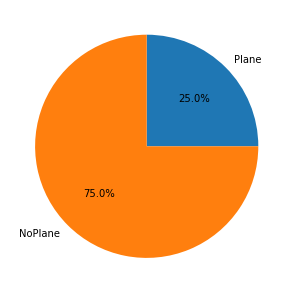

Number of plane: 8000
Number of no-plane: 24000


In [14]:
# Check if the response variable is unbalanced
number_of_plane = np.sum(df.labels==1)
number_of_noplane = np.sum(df.labels==0)

count = [number_of_plane, number_of_noplane]
title = "Plane", "NoPlane"

fig = plt.figure(figsize=(5, 7))
plt.pie(count, labels=title, autopct='%1.1f%%')
plt.show() 

print('Number of plane:', number_of_plane)
print('Number of no-plane:', number_of_noplane)

1/4th of the images contain a plane

In [15]:
# pre-processing for data and labels features
# convert the data from list to array and normalize  
images = np.array(dataset['data']) / 255.

# reshape the images: 20x20 RGB  
X = images.reshape([-1, 3, 20, 20]).transpose([0, 2, 3, 1])

# convert the labels from list to array 
status = np.array(dataset['labels'])

# one-hot-encoding
y = to_categorical(status, 2)

In [16]:
images = np.array(dataset['data'])
images.shape

(32000, 1200)

In [17]:
print(X.shape)
print(y.shape)

(32000, 20, 20, 3)
(32000, 2)


In [18]:
# split data into train-test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  test_size = 0.2, 
                                                  random_state = 123, 
                                                  stratify=y)

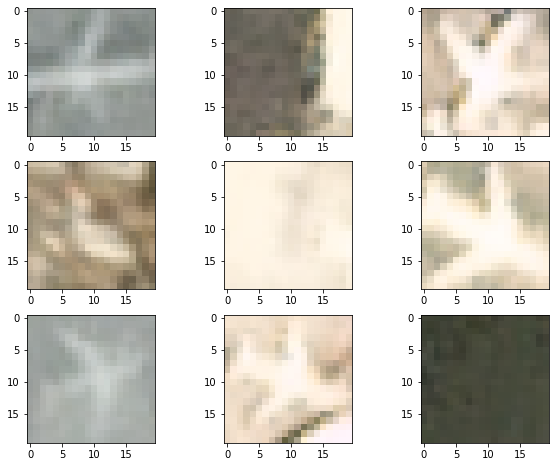

In [19]:
# check for sample images
plt.subplots(figsize=(10,8))
for i in range(0,9):
    plt.subplot(331 + i) # Why 330+1+i
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    
# show the plot
plt.show()

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25600, 20, 20, 3)
(6400, 20, 20, 3)
(25600, 2)
(6400, 2)


Now saving final train and test data to disk using pickle

In [37]:
for dt in ['X_train', 'X_test', 'y_train', 'y_test']:
    with open(f'Data/{dt}.pkl','wb') as f:
        pickle.dump(eval(dt),f, pickle.HIGHEST_PROTOCOL)

# Modeling

In [21]:
# create sequential model
model = Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(20,20, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(126, activation='relu'))
model.add(Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

In [23]:
optimizer = keras.optimizers.Adam(lr=0.00001) # optimal lr is found by manual iteration and test

# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#### Data Augmentation

In [24]:
# performing data augmentation by training image generator
datagen_test = ImageDataGenerator(#brightness_range=(0.2, 1.2), 
                                  rotation_range = 10,
                                  #fill_mode = "nearest",
                                  horizontal_flip = True,
                                  vertical_flip = True)

datagen_train = ImageDataGenerator(#brightness_range=(0.2, 1.2),
                                   rotation_range = 10,
                                   #fill_mode = "nearest",
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [25]:
datagen_train.fit(X_train)
validation_generator = datagen_test.flow(X_test, y_test, batch_size = 32)

In [11]:
# train the model
history = model.fit_generator(datagen_train.flow(X_train, y_train, batch_size = 32),
                               steps_per_epoch = len(X_train) // 32,
                               validation_data = validation_generator,
                               epochs = 25)

C:\Users\kurt_\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
800/800 [==============================] - 12s 15ms/step - loss: 0.6228 - accuracy: 0.7521 - val_loss: 0.5748 - val_accuracy: 0.7500
Epoch 2/25
800/800 [==============================] - 15s 18ms/step - loss: 0.5521 - accuracy: 0.7502 - val_loss: 0.4478 - val_accuracy: 0.7558
Epoch 3/25
800/800 [==============================] - 17s 21ms/step - loss: 0.4134 - accuracy: 0.7859 - val_loss: 0.3471 - val_accuracy: 0.8392
Epoch 4/25
800/800 [==============================] - 16s 20ms/step - loss: 0.3302 - accuracy: 0.8626 - val_loss: 0.3054 - val_accuracy: 0.8819
Epoch 5/25
800/800 [==============================] - 16s 20ms/step - loss: 0.2948 - accuracy: 0.8776 - val_loss: 0.2863 - val_accuracy: 0.8902
Epoch 6/25
800/800 [==============================] - 16s 19ms/step - loss: 0.2722 - accuracy: 0.8890 - val_loss: 0.2642 - val_accuracy: 0.8964
Epoch 7/25
800/800 [==============================] - 17s 21ms/step - loss: 0.2568 - accuracy: 0.8981 - val_loss: 0.2516 - val_accuracy:

In [12]:
model.evaluate(X_test, y_test)

200/200 [==============================] - 1s 5ms/step - loss: 0.1457 - accuracy: 0.9452


[0.14565449953079224, 0.9451562762260437]

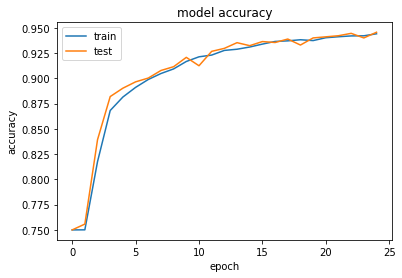

In [13]:
# accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

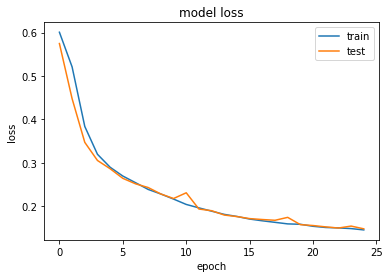

In [14]:
# loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

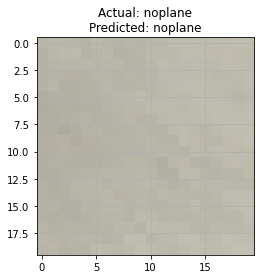

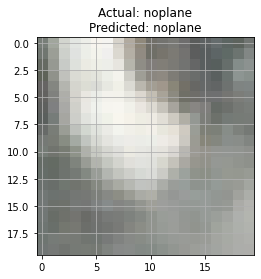

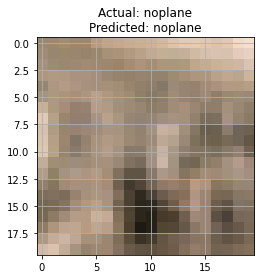

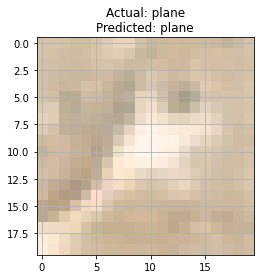

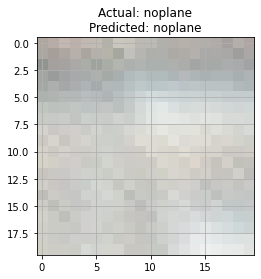

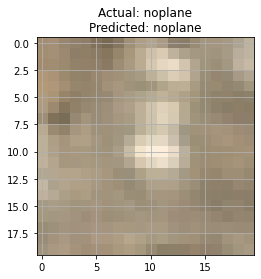

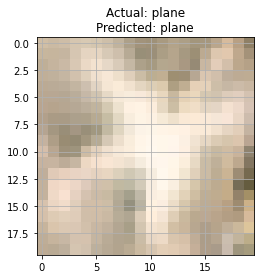

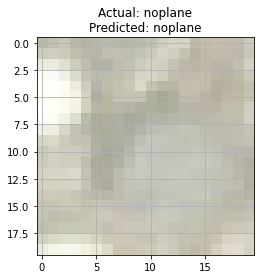

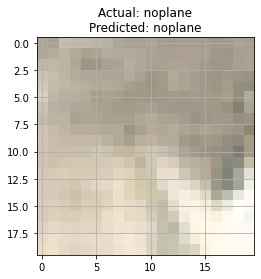

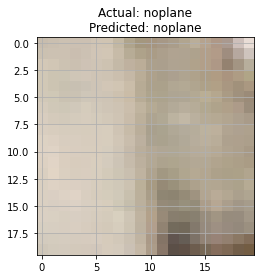

In [15]:
# check the model
names = ['noplane', 'plane']
names_label = {name:i for i, name in enumerate (names)}

pred_y= model.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)

test_y = np.argmax(y_test, axis=1)

rnd_smp = random.sample(range(0,400),10)
_labels_ = {i:name for (name,i) in names_label.items()}

for i, smp in enumerate(rnd_smp):
    
    plt.imshow(X_test[smp])
    plt.title("Actual: {}\nPredicted: {}".format(_labels_[test_y[smp]], _labels_[pred_y[smp]]))
    plt.grid(None)
    plt.show()
    pass

In [26]:
y_pred = model.predict(X_test)
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0
y_pred=np.asarray(y_pred, dtype=bool)
target_names = ['No Plane', 'Plane']
print(classification_report(y_test, y_pred, target_names=target_names))
print('Accuracy:',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

    No Plane       0.98      0.95      0.96      4800
       Plane       0.86      0.93      0.89      1600

   micro avg       0.95      0.95      0.95      6400
   macro avg       0.92      0.94      0.93      6400
weighted avg       0.95      0.95      0.95      6400
 samples avg       0.95      0.95      0.95      6400

Accuracy: 0.94515625
